# First training using the simple negation data

In [3]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim

import os
import inspect
import sys
import itertools

almost_current = os.path.abspath(inspect.getfile(inspect.currentframe()))
currentdir = os.path.dirname(almost_current)
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from plots.functions  import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_train.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_test.csv")

In [5]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [6]:
train_data.head()

,sentence1,sentence2,label
0,Winston is lively,Brooklyn is not nice,0
1,Reynold is witty,Quanda is not thankful,0
2,Hazel is brave,Charity is not witty,0
3,Sutcliff is silly,Lyle is not ambitious,0
4,Banner is ambitious,Banner is not ambitious,1


In [7]:
test_data.head()

,sentence1,sentence2,label
0,Radella is jolly,Radella is not jolly,1
1,Harris is proud,Westcott is not ambitious,0
2,Ellery is obedient,Josie is not delightful,0
3,Win is brave,Esmond is not eager,0
4,Everly is eager,Osborn is not happy,0


## Putting the sentences together

In [8]:
train_data["text"] = train_data["sentence1"]  + ", " + train_data["sentence2"]
test_data["text"] = test_data["sentence1"]  + ", " + test_data["sentence2"]
train_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
test_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]] 

In [9]:
train_data.head()

,text,label
0,"Winston is lively, Brooklyn is not nice",0
1,"Reynold is witty, Quanda is not thankful",0
2,"Hazel is brave, Charity is not witty",0
3,"Sutcliff is silly, Lyle is not ambitious",0
4,"Banner is ambitious, Banner is not ambitious",1


In [10]:
test_data.head()

,text,label
0,"Radella is jolly, Radella is not jolly",1
1,"Harris is proud, Westcott is not ambitious",0
2,"Ellery is obedient, Josie is not delightful",0
3,"Win is brave, Esmond is not eager",0
4,"Everly is eager, Osborn is not happy",0


In [11]:
labels_legend = ['no', 'yes']
anwser2int = {'no':0, 'yes':1}
int2anwser = {i[1]: i[0] for i in anwser2int.items()}
train_labels = [int2anwser[i] for i in train_data["label"].values]
test_labels = [int2anwser[i] for i in train_data["label"].values]

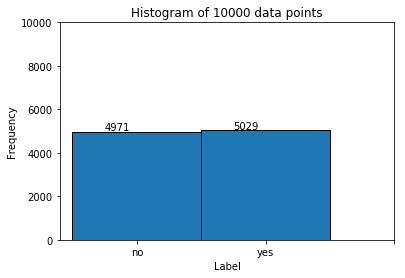

In [12]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

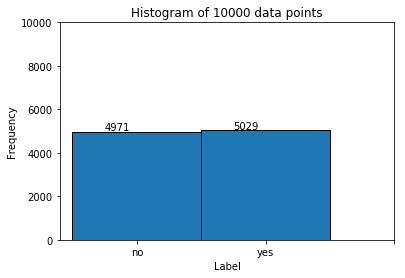

In [13]:
plot_histogram_from_labels(test_labels, labels_legend, "train data")

### Applying preprocessing function

In [14]:
print("\n=== AFTER using the function simple_pre_process_text_df ===\n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


=== AFTER using the function simple_pre_process_text_df ===

hazel is brave charity is not witty

sutcliff is silly lyle is not ambitious

banner is ambitious banner is not ambitious


## Saving the new version of the data in a csv

In [15]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_train_processed.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_test_processed.csv")


train_data.to_csv(train_data_path, header=False, index=False)
test_data.to_csv(test_data_path, header=False, index=False)

### Starting with torch

We use the `data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [16]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [17]:
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path=test_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [18]:
train, valid = train.split(0.8)

In [19]:
print('len(train):', len(train))
print('len(valid):', len(valid))
print('len(test):', len(test))

len(train): 8000
len(valid): 2000
len(test): 1000


Constructing the Vocabulary, using at maximun 25000 words

In [20]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [21]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 1335
len(LABEL.vocab): 2


Printing the 20 most frequent words

In [22]:
print(TEXT.vocab.freqs.most_common(20))

[('is', 16000), ('not', 8000), ('victorious', 778), ('gentle', 741), ('thankful', 739), ('brave', 730), ('ambitious', 729), ('eager', 726), ('polite', 723), ('obedient', 718), ('delightful', 701), ('nice', 698), ('lively', 693), ('happy', 690), ('proud', 688), ('jolly', 684), ('kind', 683), ('silly', 679), ('wonderful', 676), ('calm', 670)]


- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [23]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

TEXT.vocab.itos
word index
<unk> 0
<pad> 1
is 2
not 3
victorious 4
gentle 5
thankful 6
brave 7
ambitious 8
eager 9

TEXT.vocab.stoi
word index
i 0
love 610
trump 0


In [24]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=40,
                 output_dim=2,
                 epochs=15,
                 learning_rate=0.05,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [25]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab))
print(config)

vocab_size = 1335
batch_size = 32
embedding_dim = 100
rnn_dim = 40
output_dim = 2
epochs = 15
learning_rate = 0.05
momentum = 0.1



To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [26]:
class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
b1data = DataHolder(config, train, valid, test) 

We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [27]:
batch = next(iter(b1data.train_iter))
print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))

print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))
batch_t = batch.text.transpose(0, 1)
for example in batch_t:
    print()
    print([TEXT.vocab.itos[i] for i in example], end=" ")

batch.text.shape = torch.Size([7, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.FloatTensor


['falcon', 'is', 'ambitious', 'rain', 'is', 'not', 'kind'] 
['morrison', 'is', 'agreeable', 'morrison', 'is', 'not', 'agreeable'] 
['alberta', 'is', 'wonderful', 'nell', 'is', 'not', 'witty'] 
['maggie', 'is', 'gentle', 'newland', 'is', 'not', 'gentle'] 
['tyler', 'is', 'brave', 'scarlett', 'is', 'not', 'wonderful'] 
['northcliff', 'is', 'agreeable', 'emmett', 'is', 'not', 'ambitious'] 
['haylee', 'is', 'jolly', 'haylee', 'is', 'not', 'jolly'] 
['cutler', 'is', 'zealous', 'cutler', 'is', 'not', 'zealous'] 
['cate', 'is', 'silly', 'jane', 'is', 'not', 'delightful'] 
['shandy', 'is', 'zealous', 'shandy', 'is', 'not', 'zealous'] 
['miles', 'is', 'nice', 'miles', 'is', 'not', 'nice'] 
['rowley', 'is', 'silly', 'rowley', 'is', 'not', 'silly'] 
['hollis', 'is', 'ambitious', 'dorothy', 'is', 'not', 'polite'] 
['ford', 'is', 'proud', 'ford', 'is

Here we will define the RNN model using the `nn.module` class.

In [30]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
        
    def forward(self, x):
        """
        Apply the model to the input x
        
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """        
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        self.output = self.fc(output)

#         hidden = hidden.squeeze(0)
        out = self.output[-1]
        return out

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels
        


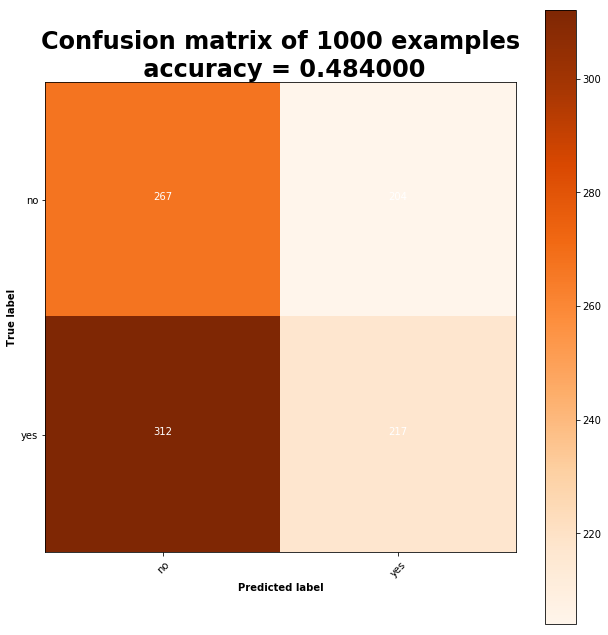

In [31]:
model = RNN(config)
test_bach = next(iter(b1data.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix_b1.png",
                      classes=labels_legend)

training function

In [32]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    for epoch in range(config.epochs):
        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train(model, train_iter, optimizer, criterion)
        valid_loss = get_valid_loss(model,valid_iter, criterion)
        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))
        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)
        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))    

In [33]:
training_loop_text_classification(model, config, b1data, "rnn.pkl")

epoch = (1/15)

train_loss = 0.699 | valid_loss = 0.710
train_acc = 0.506625

epoch = (2/15)

train_loss = 0.698 | valid_loss = 0.693
train_acc = 0.498125

epoch = (3/15)

train_loss = 0.697 | valid_loss = 0.687
train_acc = 0.501875

epoch = (4/15)

train_loss = 0.697 | valid_loss = 0.716
train_acc = 0.501125

epoch = (5/15)

train_loss = 0.696 | valid_loss = 0.703
train_acc = 0.513375

epoch = (6/15)

train_loss = 0.696 | valid_loss = 0.709
train_acc = 0.505875

epoch = (7/15)

train_loss = 0.695 | valid_loss = 0.711
train_acc = 0.516625

epoch = (8/15)

train_loss = 0.694 | valid_loss = 0.669
train_acc = 0.52625

epoch = (9/15)

train_loss = 0.689 | valid_loss = 0.695
train_acc = 0.532375

epoch = (10/15)

train_loss = 0.612 | valid_loss = 0.539
train_acc = 0.675375

epoch = (11/15)

train_loss = 0.435 | valid_loss = 0.310
train_acc = 0.817625

epoch = (12/15)

train_loss = 0.320 | valid_loss = 0.373
train_acc = 0.884125

epoch = (13/15)

train_loss = 0.248 | valid_loss = 0.271
train

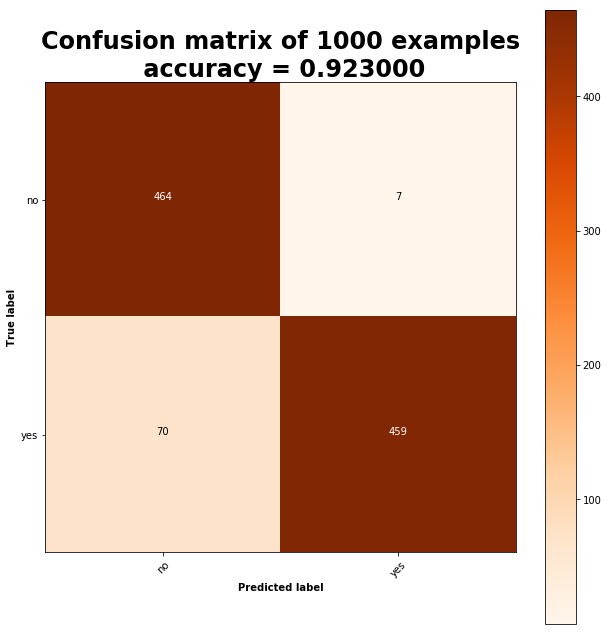

In [34]:
model = RNN(config)
model.load_state_dict(torch.load('rnn.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

## Adding visualization

In [35]:
def sentence_plot(sentences, values, title=None):
    """
    plot the values of one dimension of the hidden vector to
    each word in the sentence.

    :param sentences: sentences to be printed
    :type sentences: list of str 
    :param values: one dimension of the hidden vector 
                   for each word of the sentence
    :type values: np.array(shape=(num_sentences, sent_len))
    """
    assert len(sentences) == values.shape[0]
    for sentence in sentences:
        assert len(sentence.split()) == values.shape[1]

    all_values = []
    sentence_size = np.max([len(sentence) for sentence in sentences])
    for sid, sentence in enumerate(sentences):
        temp = np.zeros((sentence_size))
        count = 0
        for wid, word in enumerate(sentence.split()):
            temp[count: count + len(word)] = values[sid][wid]
            count = count + len(word) + 1
        all_values.append(temp)
    all_values = np.array(all_values)

    height = all_values.shape[0] 
    width = all_values.shape[1]
    
    plt.figure(figsize=(width * 1.6, height * 0.3))
    plt.title(title)
    plt.imshow(all_values, interpolation='none',
             cmap='Reds', alpha=0.5)
    plt.axis('off')
    for sid, sentence in enumerate(sentences):
        for wid, word in enumerate(sentence):
            plt.text(wid-0.2,sid+0.2,word,color='k',fontsize=12)

    plt.show()
    plt.close()

In [38]:
def get_hidden(sentences, model, mode="softmax"):
    """
    get the hidden state for each word of each sentence,
    we use softmax to normalize the values of the hidden stater

    :param sentences: sentences
    :type sentences: list of str 
    :param model: RNN model
    :type values: RNN
    :return: array with hidden states for each sentence
    :rtype: np.array
    """
    all_hiddend_states = []
    all_text = []
    for example in sentences:
        text = simple_pre_process_text(example)
        all_text.append(text) 
        text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
        text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
        text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
        text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
        _ = model.predict(text_as_tensor)
        softmax = torch.nn.Softmax(dim=2)
        sig = torch.nn.Sigmoid()
        if mode == "softmax":
            new_out = softmax(model.output)
        elif mode == "sigmoid":
            new_out = sig(model.output)
        else:
            new_out = model.output
        new_out = new_out.detach().numpy()
        new_out = new_out.reshape((len(text.split()),2))
        all_hiddend_states.append(new_out)
    return np.array(all_hiddend_states)

    

In [39]:
df_test_contra = test_data[test_data["label"]==1]
df_test_non_contra = test_data[test_data["label"]==0]
test_sentences_contra =  df_test_contra["text"].values
test_sentences_non_contra =  df_test_non_contra["text"].values

np.random.shuffle(test_sentences_contra)
np.random.shuffle(test_sentences_non_contra)

some_test_sentences_contra = test_sentences_contra[0:15]
some_test_sentences_non_contra = test_sentences_non_contra[0:15]
some_sentences = list(some_test_sentences_contra) + list(some_test_sentences_non_contra)
np.random.shuffle(some_sentences)

all_hiddend_states_contra = get_hidden(some_test_sentences_contra, model, mode="softmax")
all_hiddend_states_non_contra = get_hidden(some_test_sentences_non_contra, model, mode="softmax")
all_hiddend_states = get_hidden(some_sentences, model, mode="softmax")


## Plotting the visualiziation for contradictory sentences

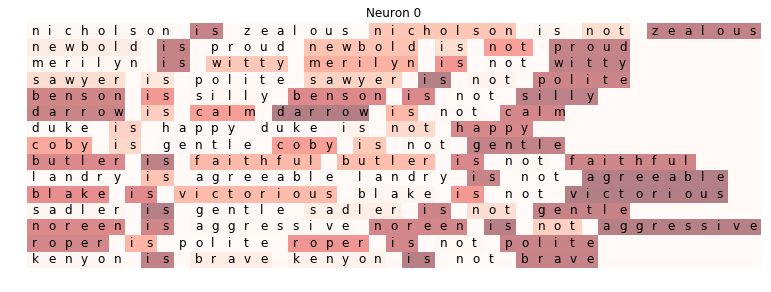

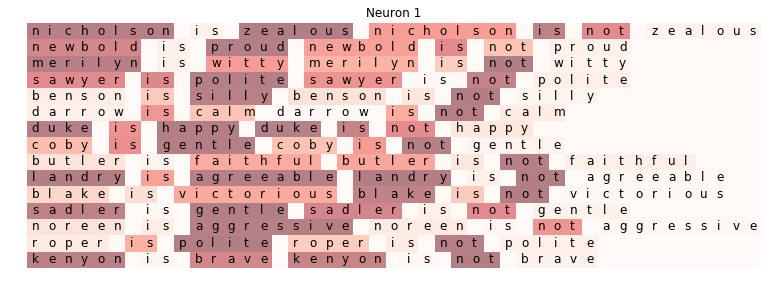

In [42]:
# sentence_plot(some_test_sentences_contra, all_hiddend_states_contra[:,:,0], title="Neuron {}".format(32))

for dim in range(2):
    sentence_plot(some_test_sentences_contra, all_hiddend_states_contra[:,:,dim], title="Neuron {}".format(dim))


## Plotting the visualiziation for all non contradictory sentences

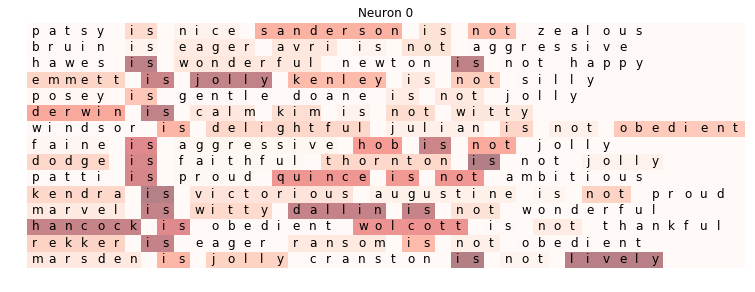

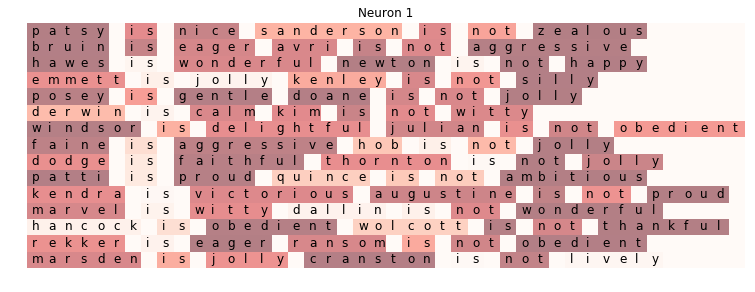

In [43]:
# sentence_plot(some_test_sentences_non_contra, all_hiddend_states_non_contra[:,:,32], title="Neuron {}".format(32))

for dim in range(2):
    sentence_plot(some_test_sentences_non_contra, all_hiddend_states_non_contra[:,:,dim], title="Neuron {}".format(dim))


## Plotting the visualiziation for all sentences

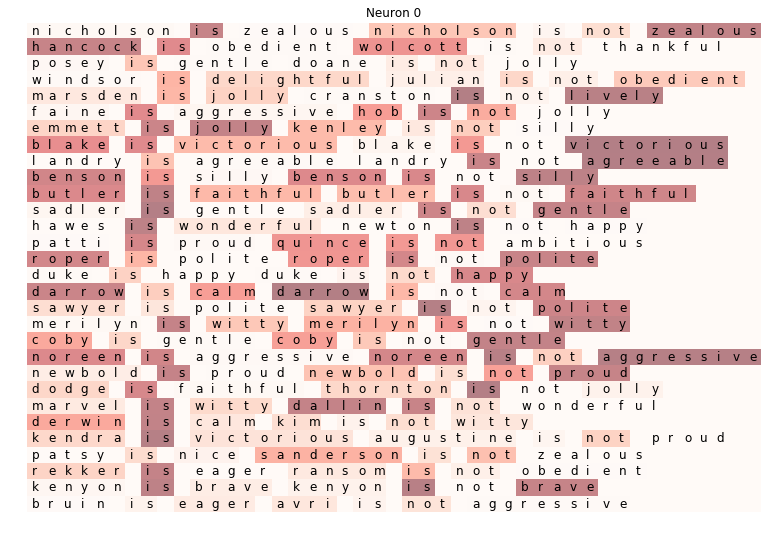

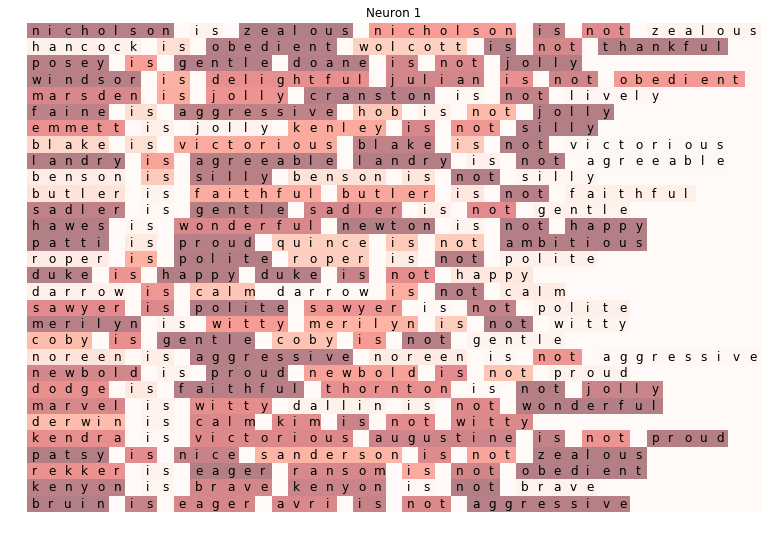

In [44]:
# sentence_plot(some_sentences, all_hiddend_states[:,:,32], title="Neuron {}".format(32))

for dim in range(2):
    sentence_plot(some_sentences, all_hiddend_states[:,:,dim], title="Neuron {}".format(dim))
